In [1]:
import re
import os
import copy
import pyperclip
import pandas as pd
import seaborn as sns
import geopandas as gpd
from shapely import wkt
import contextily as ctx
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.colors as mcolors
from shapely.geometry import Polygon, box
from shapely.plotting import plot_polygon, plot_line, plot_points
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

from functions.sparql_requests import sparql_select
from functions.general_functions import pickleload

pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 10)

plt.rcParams['font.family'] = 'Times New Roman'

# Results for non-RAG experiment

In [3]:
results = pd.concat([pickleload(f"data/with_assessment_{i}.pkl") for i in range(10)])

In [4]:
results["model_str"] = results["model_str"].replace(os.environ.get('FT_MODEL'), "mini-fine-tuned")
results["temperature"] = results["temperature"].apply(lambda x: round(x, 2))

In [5]:
results = results[results["model_str"] != "mini-fine-tuned"]

In [6]:
results["gt_results_set"] = results.apply(lambda x: set(x["gt_results_from_graph_db"][x["gt_results_column"]]) ,axis=1)

In [7]:
# # vars in question
# non-numeric, non-techinical:
# "question_category", "question_raw", "NUTS level", 'min inhabitants city', 'direction', 'big_distance', 'city_condition', 'intercardinal', 'inputs', 'answer_type'

# technical
# 'model_str', 'sysmsg', 'template', 'ontology'

# numeric:
# 'temperature'

## Full table technical paramenters (tab:res-non-rag1)
For the non-RAG experiment, way more paramenters are relevant so it is only a small table.

In [9]:
vars = ["model_str", "temperature"]



table = pd.pivot_table(results, values=["precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"], index=vars, aggfunc="mean")
group_sizes = results.groupby(vars).size()
table["group_size"] = group_sizes

table = table[["f1_non_rag", "precision_non_rag", "recall_non_rag", "hallucination_rate_nuts"]]
styled = table.style\
                .format("{:.2f}") \
                .background_gradient(subset=["precision_non_rag"], cmap="Blues") \
                .background_gradient(subset=["recall_non_rag"], cmap="Greens") \
                .background_gradient(subset=["f1_non_rag"], cmap="Oranges") \
                .background_gradient(subset=["hallucination_rate_nuts"], cmap="Greys") \
                .highlight_max(subset=["precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"], props='font-weight: bold', axis = 0)
styled

In [10]:
pyperclip.copy(table.to_latex(escape=True, float_format="%.2f"))

### some answers for gpt-4o temp 0 as positive examples (tab:ex-non-rag)

In [12]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

idx = [1464, 1495, 27875]

ex1 = results.loc[idx, ["populated_question", "question_category", "non_rag_answers", "detected_answers_non_rag", "gt_results_set", "f1_non_rag"]]
ex1

populated_question  \
1464                                             Is the NUTS region CZ06 northwest of the city of Bayreuth?   
1495                                                         What NUTS regions are within the region RO321?   
27875  What are all cities with more than a 120 k people and are less than 450 km from the NUTS region AT3?   

      question_category  \
1464    directions bool   
1495    simple topology   
27875         proximity   

                                                                                                                                                                                                                                                                                                                                                                                                      non_rag_answers  \
1464                                                                                                                                                                                                                                                                                                                                                                                                             true   
1495                                                                                                                                                                                                                                                                                                                                                                                                            RO321   
27875  Munich, Nuremberg, Linz, Salzburg, Graz, Innsbruck, Klagenfurt, Ljubljana, Zagreb, Brno, Bratislava, Venice, Verona, Padua, Trieste, Bologna, Milan, Stuttgart, Zurich, Bern, Geneva, Lausanne, Basel, Freiburg im Breisgau, Karlsruhe, Mannheim, Heidelberg, Frankfurt am Main, Wiesbaden, Mainz, Darmstadt, Ludwigshafen am Rhein, Strasbourg, Mulhouse, Freiburg im Breisgau, Metz, Nancy, Luxembourg City.   

                                                                                                                                                                                                                                                                                                                                                   detected_answers_non_rag  \
1464                                                                                                                                                                                                                                                                                                                                                                 {True}   
1495                                                                                                                                                                                                                                                                                                                                {http://data.europa.eu/nuts/code/RO321}   
27875  {mannheim, munich, zagreb, genève, ljubljana, milan, lausanne, basel, darmstadt, linz, nancy, graz, innsbruck, karlsruhe, strasbourg, nürnberg, padova, verona, metz, wiesbaden, freiburg, brno, ludwigshafenamrhein, bratislava, bologna, trieste, salzburg, heidelberg, bern, klagenfurtamwörthersee, frankfurtammain, stuttgart, zürich, mulhouse, venice, mainz}   

                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [13]:
pyperclip.copy(ex1.to_latex(escape=True, float_format="%.2f",index=False))

The second 2 examples are straight forward

#### "False Positives"
They are all smaller than 120 k inhabitants except for venice

In [16]:
cleaning_regex = r"[^\w']"
ex1.iloc[2].detected_answers_non_rag - {re.sub(cleaning_regex, '', x).lower() for x in ex1.iloc[2].gt_results_set}

{'klagenfurtamwörthersee', 'mulhouse', 'nancy', 'venice'}

# Map for Example (fig:map-ex-non-rag)

In [18]:
q = """
PREFIX geo: <http://www.opengis.net/ont/geosparql#> 
PREFIX geof: <http://www.opengis.net/def/function/geosparql/> 
PREFIX gn: <https://www.geonames.org/ontology#> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 

SELECT ?city ?cityName ?population ?cityWKT ?regionWKT
WHERE {
  ?city a gn:Feature ;
        gn:population ?population ;
    	gn:name ?cityName ;
        geo:hasGeometry ?cityGeom .
  ?region a skos:Concept ;
          skos:notation "AT3" ;
          geo:hasGeometry ?regionGeom .
  ?cityGeom geo:asWKT ?cityWKT .
  ?regionGeom geo:asWKT ?regionWKT .
  FILTER(?population > 120000)
  FILTER(geof:distance(?cityWKT, ?regionWKT) < 450000)
}"""

In [19]:
df = sparql_select(q)
region = df.regionWKT.iloc[2]
df["geometry"] = df["cityWKT"].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs=3035)
gdf['marker_size'] = gdf['population'] / gdf['population'].max() * 200

gdf["in_non_rag"] = gdf["cityName"].apply(lambda x: re.sub(cleaning_regex, '', x).lower() in ex1.detected_answers_non_rag.iloc[2])

gdf["FP"] = gdf["cityName"].apply(lambda x: (re.sub(cleaning_regex, '', x).lower() in ex1.detected_answers_non_rag.iloc[2]) & (x not in ex1.gt_results_set.iloc[2]))

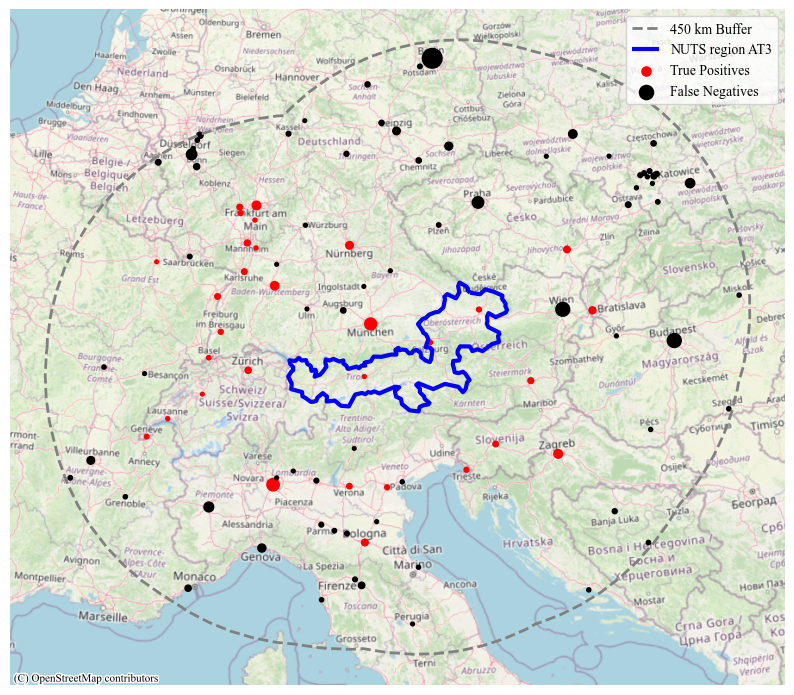

In [20]:
fig, ax = plt.subplots(1, figsize=(10, 10))

gpd.GeoSeries([wkt.loads(region).buffer(450000)]).boundary.plot(ax=ax, color="grey", linewidth=2, linestyle="dashed", label="450 km Buffer")
gpd.GeoSeries([wkt.loads(region)]).boundary.plot(ax=ax, color="blue", linewidth=3, label="NUTS region AT3")

gdf[gdf["in_non_rag"]].plot(ax=ax, color="red", markersize=gdf[gdf["in_non_rag"]]["marker_size"], label="True Positives")
gdf[~gdf["in_non_rag"]].plot(ax=ax, color="black", markersize=gdf[~gdf["in_non_rag"]]["marker_size"], label="False Negatives")
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

ax.axis("off")
ax.legend()

fig.savefig("pics/example_buffer.png", bbox_inches='tight')

Findings:

No cities in Hungary or Poland detected 

Nothing on the outer parts of the buffer

Even some huge close cities missing (Prague, Vienna??)

But detected some smaller remote cities like Strasbourg and bologna

## Full table non-technical parameters (tab:res-non-rag-cats)

In [23]:
vars = ["question_category"]

table = pd.pivot_table(results, values=["precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"], index=vars, aggfunc="mean", sort=False)

table = table[["f1_non_rag", "precision_non_rag", "recall_non_rag", "hallucination_rate_nuts"]]
styled = table.style\
                .format("{:.2f}") \
                .highlight_max(subset=["precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"], props='font-weight: bold', axis = 0)
                # .background_gradient(subset=["precision_non_rag"], cmap="Blues") \
                # .background_gradient(subset=["recall_non_rag"], cmap="Greens") \
                # .background_gradient(subset=["f1_non_rag"], cmap="Oranges") \
                # .background_gradient(subset=["hallucination_rate_nuts"], cmap="Purples") \
                # .map(lambda x: 'color: black; background-color: transparent' if pd.isnull(x) else '') \

print(table.to_latex(escape=True, float_format="%.2f",index=True))
table

\begin{tabular}{lrrrl}
\toprule
 & f1\_non\_rag & precision\_non\_rag & recall\_non\_rag & hallucination\_rate\_nuts \\
question_category &  &  &  &  \\
\midrule
simple topology & 0.50 & 0.63 & 0.47 & 0.12 \\
neighbors & 0.42 & 0.48 & 0.42 & 0.20 \\
directions bool & 0.54 & 0.54 & 0.54 & NaN \\
directions open & 0.43 & 0.44 & 0.43 & NaN \\
proximity & 0.26 & 0.36 & 0.25 & NaN \\
combinations & 0.06 & 0.08 & 0.05 & 0.10 \\
\bottomrule
\end{tabular}



f1_non_rag  precision_non_rag  recall_non_rag  \
question_category                                                  
simple topology      0.504818           0.631771        0.473196   
neighbors            0.418035           0.479391        0.415966   
directions bool      0.535205           0.535205        0.535205   
directions open      0.430521           0.437063        0.427584   
proximity            0.257406           0.359623        0.245775   
combinations         0.055512           0.080964        0.053120   

                  hallucination_rate_nuts  
question_category                          
simple topology                   0.12371  
neighbors                        0.195984  
directions bool                       NaN  
directions open                       NaN  
proximity                             NaN  
combinations                     0.103557

## Only with the best model/temp combination (tab:res-non-rag-cats-best)

In [25]:
vars = ["question_category"]

df = results[(results["model_str"] == "gpt-4o") & (results["temperature"] == 0)]

table = pd.pivot_table(df, values=["precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"], index=vars, aggfunc="mean", sort=False)

table = table[["f1_non_rag", "precision_non_rag", "recall_non_rag", "hallucination_rate_nuts"]]
styled = table.style\
                .format("{:.2f}") \
                .background_gradient(subset=["precision_non_rag"], cmap="Blues") \
                .background_gradient(subset=["recall_non_rag"], cmap="Greens") \
                .background_gradient(subset=["f1_non_rag"], cmap="Oranges") \
                .background_gradient(subset=["hallucination_rate_nuts"], cmap="Purples") \
                .map(lambda x: 'color: black; background-color: transparent' if pd.isnull(x) else '') \
                .highlight_max(subset=["precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"], props='font-weight: bold', axis = 0)
styled

In [26]:
print(table.to_latex(escape=True, float_format="%.2f",index=True))

\begin{tabular}{lrrrl}
\toprule
 & f1\_non\_rag & precision\_non\_rag & recall\_non\_rag & hallucination\_rate\_nuts \\
question_category &  &  &  &  \\
\midrule
simple topology & 0.64 & 0.80 & 0.57 & 0.06 \\
neighbors & 0.51 & 0.54 & 0.53 & 0.18 \\
directions bool & 0.47 & 0.47 & 0.47 & NaN \\
directions open & 0.51 & 0.52 & 0.50 & NaN \\
proximity & 0.32 & 0.38 & 0.33 & NaN \\
combinations & 0.08 & 0.14 & 0.06 & 0.04 \\
\bottomrule
\end{tabular}



# All questions (tab:by-question-non-rag)

In [28]:
vars = ["question_raw"]

df = results[results["temperature"] < 0.5]
df = df[df["model_str"] == "gpt-4o"]

table = pd.pivot_table(df, values=["precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"], index=vars, aggfunc="mean", sort=False)

table = table[["f1_non_rag", "precision_non_rag", "recall_non_rag", "hallucination_rate_nuts"]]
styled = table.style\
                .format("{:.2f}") \
                .background_gradient(subset=["precision_non_rag"], cmap="Blues") \
                .background_gradient(subset=["recall_non_rag"], cmap="Greens") \
                .background_gradient(subset=["f1_non_rag"], cmap="Oranges") \
                .background_gradient(subset=["hallucination_rate_nuts"], cmap="Purples") \
                .map(lambda x: 'color: black; background-color: transparent' if pd.isnull(x) else '') \
                .highlight_max(subset=["precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"], props='font-weight: bold', axis = 0)
styled

In [29]:
print(table.to_latex(escape=True, float_format="%.2f",index=True).replace("NaN", "-"))

\begin{tabular}{lrrrl}
\toprule
 & f1\_non\_rag & precision\_non\_rag & recall\_non\_rag & hallucination\_rate\_nuts \\
question_raw &  &  &  &  \\
\midrule
What are all the NUTS regions that contain the city CITY? & 0.49 & 0.72 & 0.40 & 0.02 \\
What NUTS regions are within the region CODE? & 0.78 & 0.88 & 0.75 & 0.10 \\
Is the NUTS region CODE bordering the region CODE? & 0.83 & 0.83 & 0.83 & - \\
What regions of the same level are neighbors of the NUTS region CODE? & 0.38 & 0.45 & 0.39 & 0.09 \\
What are the second order neighbors of the same NUTS level for the NUTS region CODE? & 0.28 & 0.31 & 0.35 & 0.30 \\
Is NUTS region CODE DIRECTION of NUTS region CODE? & 0.52 & 0.52 & 0.52 & - \\
Is the NUTS region CODE DIRECTION of the city of CITY? & 0.52 & 0.52 & 0.52 & - \\
To which direction is CITY from CITY? & 0.63 & 0.63 & 0.62 & - \\
CITY is to which direction of NUTS region CODE? & 0.31 & 0.32 & 0.30 & - \\
Is CITY within SMALLDISTANCE km of the NUTS region CODE? & 0.57 & 0.57 & 0.57

# Create the maps

In [31]:
# Get all cities with more than 20000 inhabitants
q = """
PREFIX geo: <http://www.opengis.net/ont/geosparql#> 
PREFIX geof: <http://www.opengis.net/def/function/geosparql/> 
PREFIX gn: <https://www.geonames.org/ontology#> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 

SELECT ?city ?cityName ?population ?cityWKT
WHERE {
  ?city a gn:Feature ;
        gn:population ?population ;
    	gn:name ?cityName ;
        geo:hasGeometry ?cityGeom .
  ?cityGeom geo:asWKT ?cityWKT .
  FILTER(?population > 20000)
}"""

# get only the cities that were at least 10 times the example

df = sparql_select(q)
df["cityWKT"] = df["cityWKT"].apply(wkt.loads)

In [32]:
all_gdfs1 = []

city_answer = results[results.answer_type == "single_city"]

In [33]:
def temp(df):
    vals = df.values.tolist()
    if len(vals) > 0:
        res = vals[0][0]
    else:
        res = ""
    return res

city_answer["output_city"] = city_answer.gt_results_from_graph_db.apply(temp)

C:\Users\arbeit\AppData\Local\Temp\ipykernel_34980\3183675427.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_answer["output_city"] = city_answer.gt_results_from_graph_db.apply(temp)


In [34]:
num_ex = city_answer[["output_city", "precision_non_rag", "recall_non_rag", "f1_non_rag"]].groupby("output_city").size()

In [35]:
mean_quality_values_by_city = city_answer[["output_city", "precision_non_rag", "recall_non_rag", "f1_non_rag"]].groupby("output_city").mean()
idx = num_ex[num_ex>6].index
idx = idx[idx != ""]
idx = idx[idx != "Akrotiri"]
idx = idx[idx != "Tsada - Tremithousa - Tala (Borders)"]
idx

Index(['Athens', 'Augsburg', 'Barcelona', 'Berlin', 'Brugge', 'Brussels',
       'Bucharest', 'Budapest', 'Cluj-Napoca', 'Copenhagen', 'Dresden',
       'Dublin', 'Győr', 'Hamburg', 'Istanbul', 'Kraków', 'Kyiv', 'Köln',
       'Las Palmas de Gran Canaria', 'Leipzig', 'London', 'Lyon', 'Madrid',
       'Mannheim', 'Milan', 'Minsk', 'Munich', 'Nantes', 'Naples', 'Paris',
       'Prague', 'Rennes', 'Rome', 'Saint Petersburg', 'Sofia', 'Stockholm',
       'Toulouse', 'Vienna', 'Vilnius', 'Warsaw', 'Zagreb', 'Zaragoza',
       'İzmir', 'Łódź', 'Žilina'],
      dtype='object', name='output_city')

In [36]:
example_cities_with_geoms = mean_quality_values_by_city.loc[idx, :].merge(df, how="left", left_index=True, right_on="cityName")
gdf = gpd.GeoDataFrame(example_cities_with_geoms, geometry="cityWKT", crs=3035)

gdf['marker_size'] = gdf['population'] / gdf['population'].max() * 250
all_gdfs1.append(gdf)

### All cities as examples

In [38]:
results.loc[:, "has_city_input"] = results["inputs"].apply(lambda x: "CITY" in x.keys())
with_city = results[results["has_city_input"]]
with_city.loc[:, "input_city"] = with_city["inputs"].apply(lambda x: x["CITY"] if type(x["CITY"])==str else x["CITY"][0])

C:\Users\arbeit\AppData\Local\Temp\ipykernel_34980\3990714576.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  with_city.loc[:, "input_city"] = with_city["inputs"].apply(lambda x: x["CITY"] if type(x["CITY"])==str else x["CITY"][0])


In [39]:
num_ex = with_city[["input_city", "precision_non_rag", "recall_non_rag", "f1_non_rag"]].groupby("input_city").size()
mean_quality_values_by_city = with_city[["input_city", "precision_non_rag", "recall_non_rag", "f1_non_rag"]].groupby("input_city").mean()
idx = num_ex[num_ex>6].index
idx = idx[idx != ""]
idx = idx[idx != "Akrotiri"]
idx = idx[idx != "Tsada - Tremithousa - Tala (Borders)"]

example_cities_with_geoms = mean_quality_values_by_city.loc[idx, :].merge(df, how="left", left_index=True, right_on="cityName")
gdf = gpd.GeoDataFrame(example_cities_with_geoms, geometry="cityWKT", crs=3035)

gdf['marker_size'] = gdf['population'] / gdf['population'].max() * 400
all_gdfs1.append(gdf)

C:\Users\arbeit\AppData\Local\Temp\ipykernel_34980\613509032.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


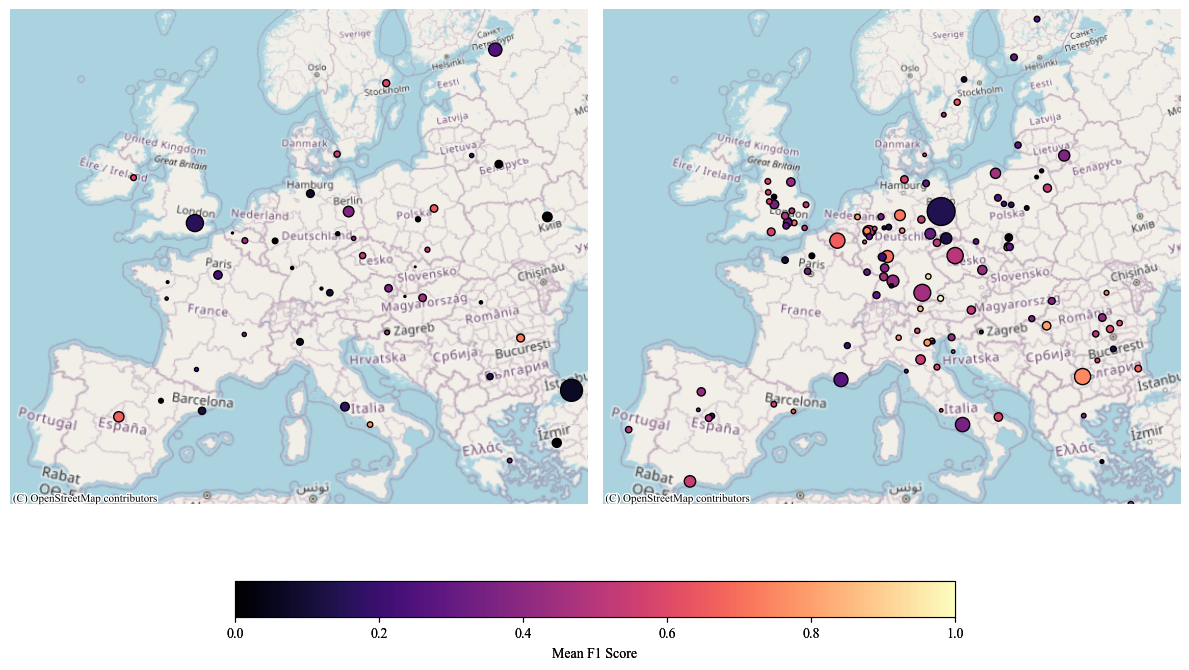

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(12, 12))
for gdf, ax in zip(all_gdfs1, axs):
    norm = mcolors.Normalize(vmin=0, vmax=1)
    cmap = plt.cm.magma
    
    gdf.plot(ax=ax, color=[cmap(norm(value)) for value in gdf['f1_non_rag']], markersize=gdf["marker_size"], edgecolor="black")
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=4)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.03])
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label='Mean F1 Score', orientation = 'horizontal')
    ax.set_xlim(2500000, 6000000)
    ax.set_ylim(1500000, 4500000)
    ax.axis("off")

plt.tight_layout()

In [41]:
for gdf in all_gdfs1:
    print(pearsonr(gdf.f1_non_rag, gdf.population))

PearsonRResult(statistic=-0.00901610749463991, pvalue=0.9525789644342916)
PearsonRResult(statistic=-0.005386940324940733, pvalue=0.9544354036558612)


There is no correlation between population and the mean f1 score

### The same for NUTS codes

In [44]:
q = """
PREFIX geo: <http://www.opengis.net/ont/geosparql#> 
PREFIX geof: <http://www.opengis.net/def/function/geosparql/> 
PREFIX gn: <https://www.geonames.org/ontology#> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 

SELECT ?city ?notation ?codeWKT
WHERE {
  ?code a skos:Concept ;
    	skos:notation ?notation ;
        geo:hasGeometry ?codeGeom .
  ?codeGeom geo:asWKT ?codeWKT .
}"""

# get only the cities that were at least 10 times the example

df = sparql_select(q)
df["codeWKT"] = df["codeWKT"].apply(wkt.loads)

In [45]:
all_gdfs = []
level = 2

results.loc[:, "has_input_codes"] = results["inputs"].apply(lambda x: "CODE" in x.keys())
with_code = results[results["has_input_codes"]]
with_code.loc[:, "input_code"] = with_code["inputs"].apply(lambda x: x["CODE"] if type(x["CODE"])==str else x["CODE"][0])
with_code = with_code[with_code["NUTS level"]==level]

C:\Users\arbeit\AppData\Local\Temp\ipykernel_34980\2042331774.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  with_code.loc[:, "input_code"] = with_code["inputs"].apply(lambda x: x["CODE"] if type(x["CODE"])==str else x["CODE"][0])


In [46]:
num_ex = with_code[["input_code", "precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"]].groupby("input_code").size()
mean_quality_values_by_city = with_code[["input_code", "precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"]].groupby("input_code").mean()
idx = num_ex[num_ex>6].index

In [47]:
example_cities_with_geoms = mean_quality_values_by_city.loc[idx, :].merge(df, how="left", left_index=True, right_on="notation")
gdf = gpd.GeoDataFrame(example_cities_with_geoms, geometry="codeWKT", crs=3035)
all_gdfs.append(gdf)

In [48]:
code_as_result = results[results["answer_type"] == "code_iri"]
code_as_result = code_as_result[[type(x) == pd.DataFrame for x in code_as_result["gt_results_from_graph_db"]]]
code_as_result["gt_results_codes"] = code_as_result["gt_results_from_graph_db"].apply(lambda x: x.values.tolist())
code_as_result = code_as_result.explode("gt_results_codes")
code_as_result["gt_results_codes"] = code_as_result["gt_results_codes"].apply(lambda x: x[0].split("/")[-1] if type(x) == list else None)

In [49]:
num_ex = code_as_result[["gt_results_codes", "precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"]].groupby("gt_results_codes").size()
mean_quality_values_by_city = code_as_result[["gt_results_codes", "precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"]].groupby("gt_results_codes").mean()
idx = num_ex[num_ex>6].index

In [50]:
example_cities_with_geoms = mean_quality_values_by_city.loc[idx, :].merge(df, how="left", left_index=True, right_on="notation")
gdf = gpd.GeoDataFrame(example_cities_with_geoms, geometry="codeWKT", crs=3035)
gdf = gdf[[len(x) == 4 for x in gdf.notation]]
all_gdfs.append(gdf)

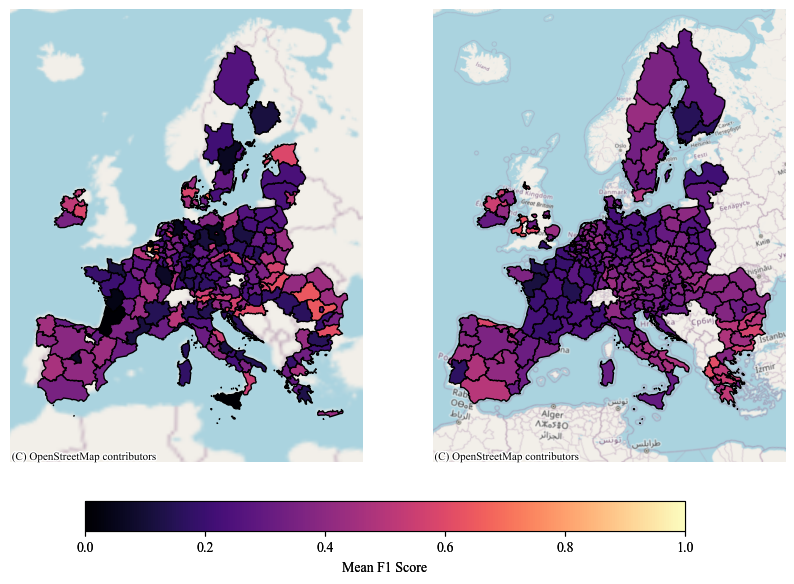

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
for ax, gdf in zip(axs, all_gdfs):
    norm = mcolors.Normalize(vmin=0, vmax=1)
    cmap = plt.cm.magma
    
    gdf.plot(ax=ax, color=[cmap(norm(value)) for value in gdf['f1_non_rag']], edgecolor="black")
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.03])
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label='Mean F1 Score', orientation = 'horizontal')
    ax.set_xlim(2500000, 6000000)
    ax.set_ylim(1000000, 5500000)
    ax.axis("off")

# MAPS (fig:map-spatial-non-rag)

C:\Users\arbeit\AppData\Local\Temp\ipykernel_34980\1326075335.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


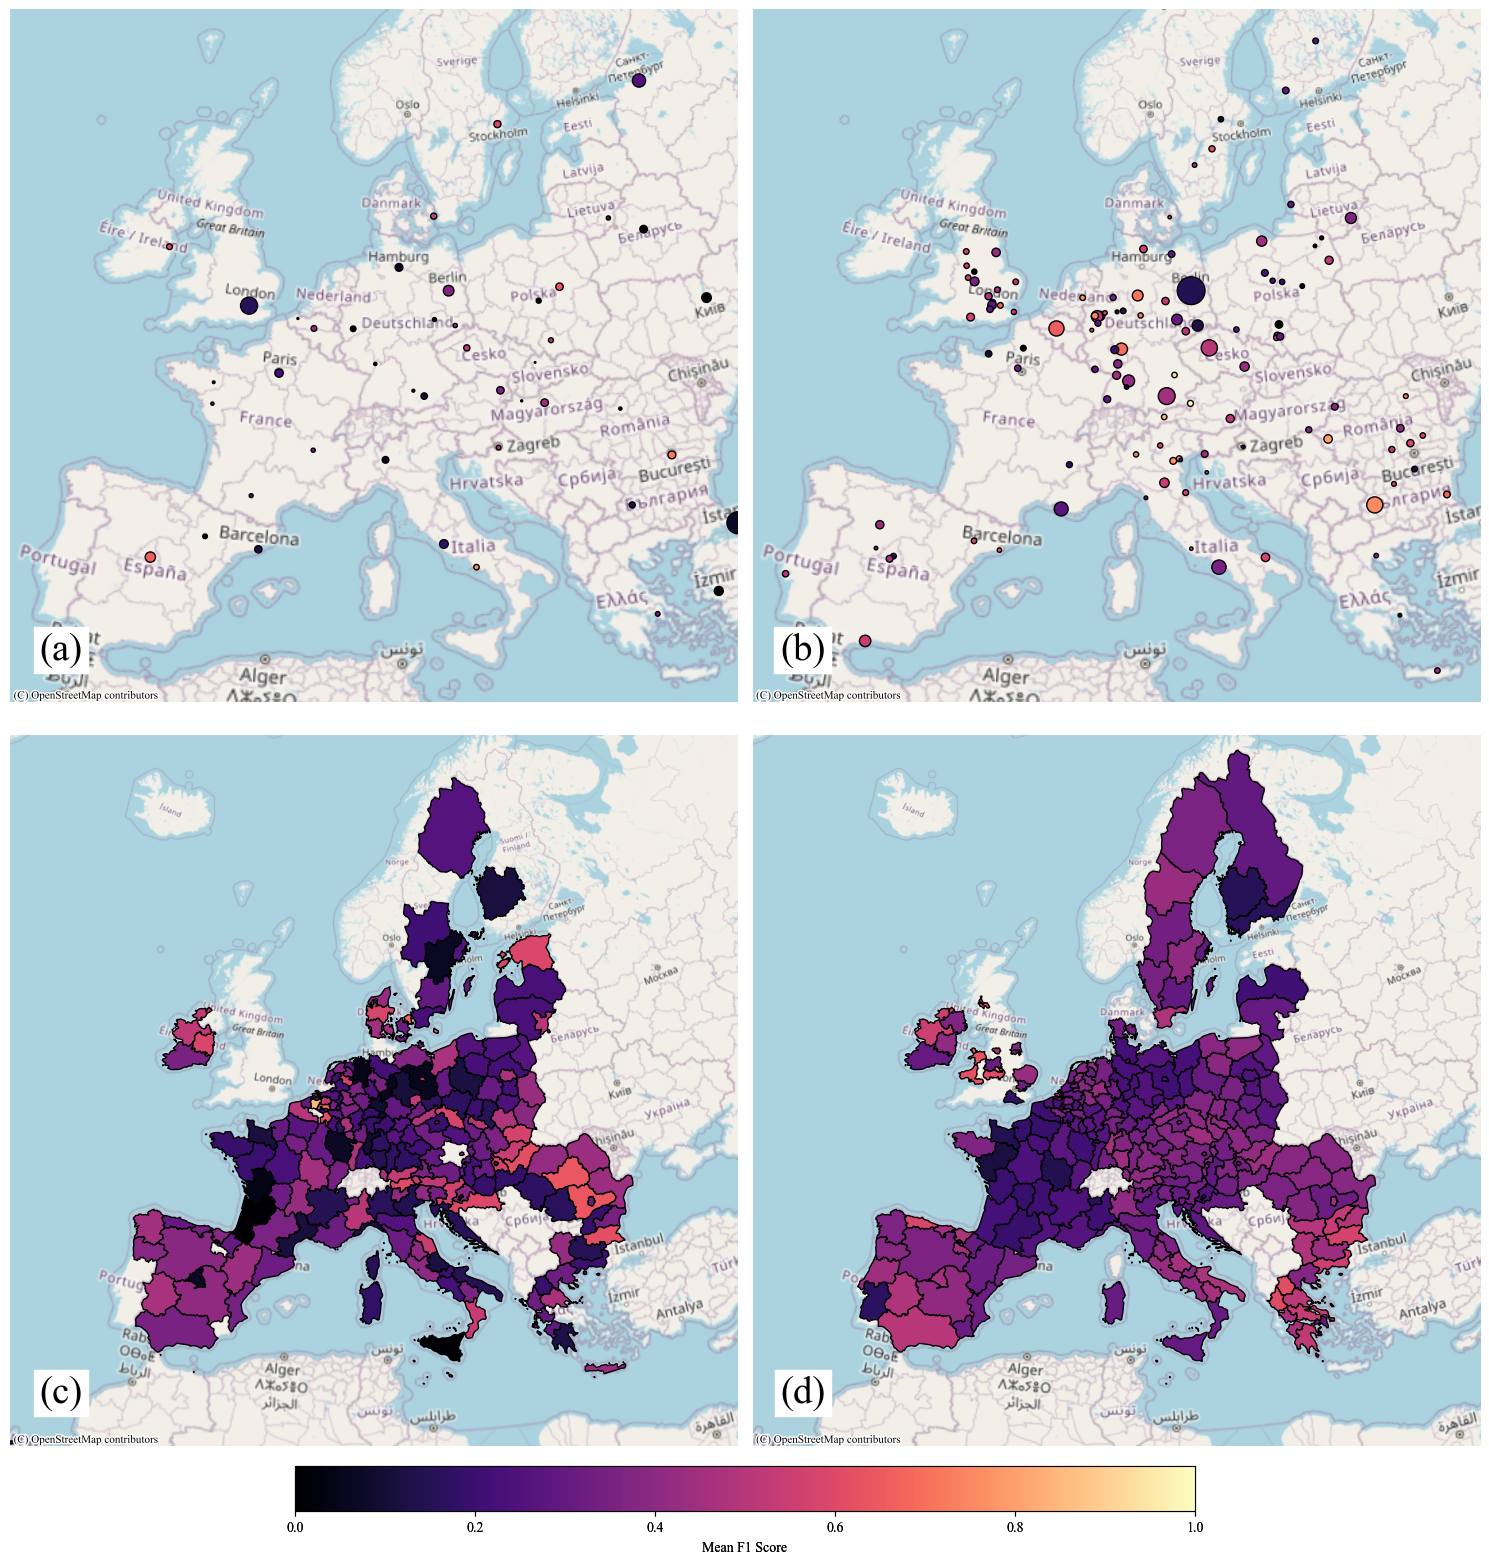

In [53]:
letters = ["a", "b", "c", "d"]

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for gdf, ax in zip(all_gdfs1, axes[0]):
    norm = mcolors.Normalize(vmin=0, vmax=1)
    cmap = plt.cm.magma
    
    gdf.plot(ax=ax, color=[cmap(norm(value)) for value in gdf['f1_non_rag']], markersize=gdf["marker_size"], edgecolor="black")
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=4)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    # cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.03])
    # cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label='Mean F1 Score', orientation = 'horizontal')
    ax.set_xlim(2504173.807828995, 5901144.183018832)
    ax.set_ylim(1352828.6899153944, 4587174.789333616)
    ax.axis("off")
    t = ax.text(0.1, 0.05, f"({letters.pop(0)})", 
            transform=ax.transAxes,
            fontsize=28,
            fontdict={'family': 'Times New Roman'},
            ha='right',
            va='bottom')
    t.set_bbox(dict(facecolor='white', alpha=1, edgecolor="white"))
    
for ax, gdf in zip(axes[1], all_gdfs):
    norm = mcolors.Normalize(vmin=0, vmax=1)
    cmap = plt.cm.magma
    
    gdf.plot(ax=ax, color=[cmap(norm(value)) for value in gdf['f1_non_rag']], edgecolor="black")
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=4)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    cbar_ax = fig.add_axes([0.2, -0.025, 0.6, 0.03])
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label='Mean F1 Score', orientation = 'horizontal')
    ax.set_xlim(2000000, 6500000)
    ax.set_ylim(1000000, 5400000)
    ax.axis("off")
    t = ax.text(0.1, 0.05, f"({letters.pop(0)})", 
        transform=ax.transAxes,
        fontsize=28,
        fontdict={'family': 'Times New Roman'},
        ha='right',
        va='bottom')
    t.set_bbox(dict(facecolor='white', alpha=1, edgecolor="white"))

plt.tight_layout()
fig.savefig("pics/accuracy_by_city_and_nuts.png", bbox_inches="tight")

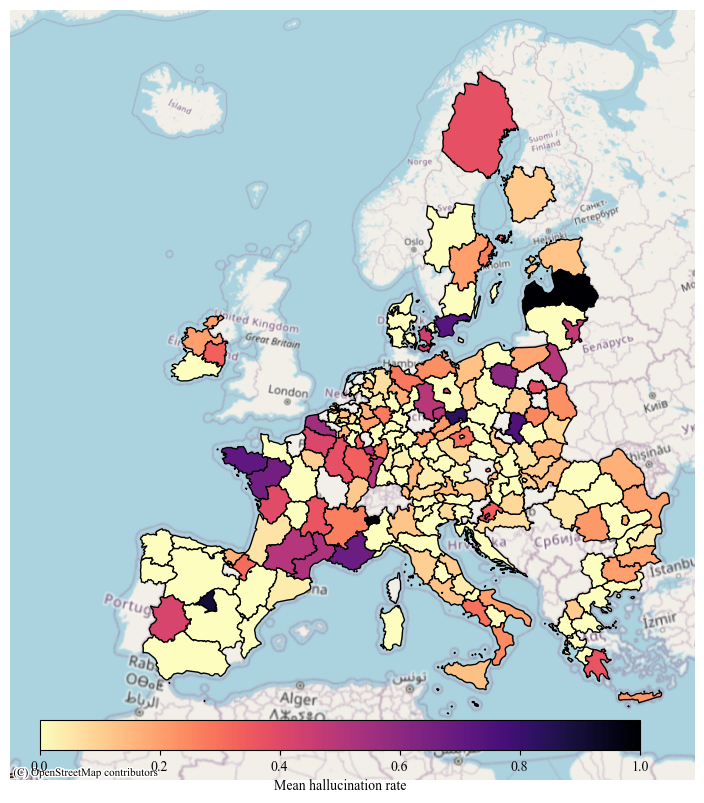

In [54]:
gdf = all_gdfs[0]
norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = plt.cm.magma_r

fig, ax = plt.subplots(1, figsize=(10, 10))
gdf.plot(ax=ax, color=[cmap(norm(value)) for value in gdf['hallucination_rate_nuts']], edgecolor="black")
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=4)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.2, 0.14, 0.6, 0.03])
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label='Mean hallucination rate', orientation = 'horizontal')
ax.set_xlim(2000000, 6000000)
ax.set_ylim(1000000, 5500000)
ax.axis("off")

fig.savefig("pics/hallucination-map.png", bbox_inches="tight")

# Non technical Varibales

In [56]:
def plot_two_vars(df, ax, t=[15000, 50000, 120000], var1="NUTS level", var2="question_raw", text="(a)"):
    pd.set_option("display.max_rows", 100)
    vars = [var1, var2]
    
    col2_sets = df.groupby(vars[0])[vars[1]].apply(set)
    common_col2 = set.intersection(*col2_sets)
    df = df[df[vars[1]].isin(common_col2)]
    
    min_size = df.groupby(vars).size().min()
    print(min_size)
    
    def sample_group(group):
        return group.sample(n=min_size, replace=False)
    
    grouped = df.groupby(vars)
    valid_groups = grouped.filter(lambda x: len(x) >= min_size)
    sampled_df = valid_groups.groupby(vars).apply(sample_group).reset_index(drop=True)
    
    table = pd.pivot_table(sampled_df, values=["precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"], index=vars, aggfunc="mean")
    group_sizes = sampled_df.groupby(vars).size()
    
    table = table[["f1_non_rag", "precision_non_rag", "recall_non_rag"]]
    table["group_size"] = group_sizes
    
    grouped = table.groupby(level=vars[1])
    
    unique_values = list(grouped.groups.keys())#
    # colormap = plt.cm.Set1
    # colors = {val: colormap(i / (len(unique_values) - 1)) for i, val in enumerate(unique_values)}
    
    for level_2, group in grouped:
        ax.plot(
            group.index.get_level_values(vars[0]),  # X-axis: Index_Level_1
            group['f1_non_rag'],                                # Y-axis: Column value
            marker='o',
            label=f"{level_2}"#,
            # color=colors[level_2]
        )

    ret = copy.deepcopy(table)
    
    new_vars = vars[0]
    table = pd.pivot_table(sampled_df, values=["precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"], index=new_vars, aggfunc="mean")
    group_sizes = sampled_df.groupby(new_vars).size()
    
    table = table[["f1_non_rag", "precision_non_rag", "recall_non_rag"]]
    table["group_size"] = group_sizes
    ax = table.f1_non_rag.plot(ax=ax, color="black", linewidth=2, label="Mean over all questions")
    
    ax.legend(title=vars[1], bbox_to_anchor=(1.02, -0.1))
    ax.set_xlabel(vars[0], fontsize=16)
    ax.set_ylabel("F1 Score", fontsize=16)

    ax.set_xticks(t)
    ax.grid(linestyle='dashed')
    ax.set_ylim((0, 0.95))
    ax.text(0.085, 0.03, text, 
        transform=ax.transAxes,
        fontsize=16,
        ha='right',
        va='bottom')

    return ret, sampled_df

### (fig:f1-by-non-technical)

160


C:\Users\arbeit\AppData\Local\Temp\ipykernel_34980\2013107112.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = valid_groups.groupby(vars).apply(sample_group).reset_index(drop=True)


Spearman overall:  SignificanceResult(statistic=0.0006285237796535716, pvalue=0.9635812483265545)
Spearman for What NUTS regions are within the region CODE?:
 SignificanceResult(statistic=0.5186084802243259, pvalue=2.1252548949941747e-34)
179
PearsonRResult(statistic=0.04781841829996089, pvalue=0.026678145820871964)


C:\Users\arbeit\AppData\Local\Temp\ipykernel_34980\2013107112.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = valid_groups.groupby(vars).apply(sample_group).reset_index(drop=True)


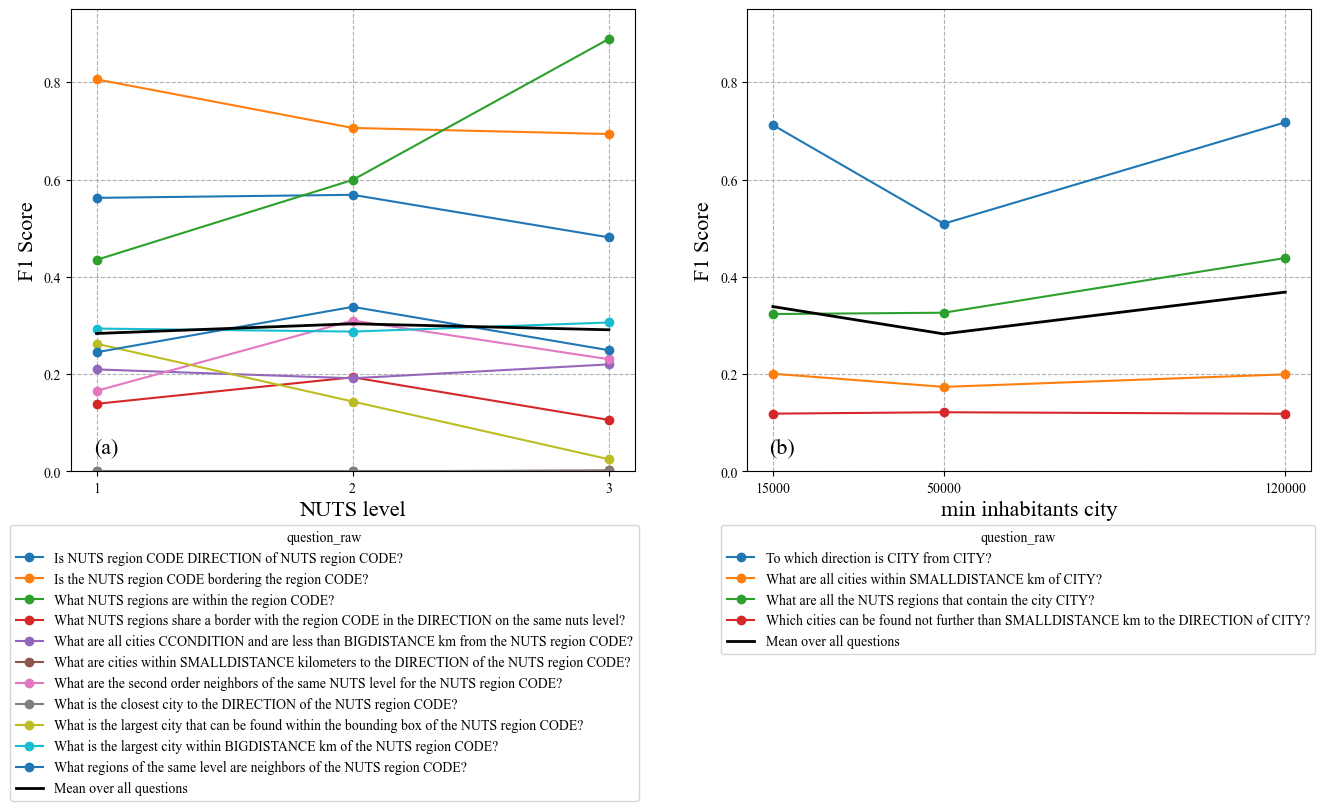

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

ax = axs[0]

df = copy.deepcopy(results)
df = df[df.variables.astype(str).str.contains("CODE")] # always chose the correct subset of questions!
df = df[~df.variables.astype(str).str.contains("CITY")]
df = df[~df.intercardinal]

table, for_corr = plot_two_vars(df, ax, [1, 2, 3], var1='NUTS level')

q1 = 'What NUTS regions are within the region CODE?'
# q2 = 'Is the NUTS region CODE bordering the region CODE?'
for_corr1 = for_corr[for_corr.question_raw == q1]
# for_corr2 = for_corr[for_corr.question_raw == q2]

print("Spearman overall: ", spearmanr(for_corr['NUTS level'], for_corr['f1_non_rag']))
print(f"Spearman for {q1}:\n", spearmanr(for_corr1['NUTS level'], for_corr1['f1_non_rag']))


###### Popsize
ax = axs[1]
df = copy.deepcopy(results)
df = df[df.variables.astype(str).str.contains("CITY")] # always chose the correct subset of questions!
df = df[~df.variables.astype(str).str.contains("CODE")]
df = df[~df.intercardinal]

table, for_corr = plot_two_vars(df, ax, var1='min inhabitants city', text="(b)")

print(pearsonr(for_corr['min inhabitants city'].astype(float), for_corr['f1_non_rag']))

fig.savefig("pics/f1-by-non-technical.png", bbox_inches="tight")

# KDE plot for performance by distance of the city (fig:kde-plots)

In [60]:
q = """
PREFIX geo: <http://www.opengis.net/ont/geosparql#> 
PREFIX geof: <http://www.opengis.net/def/function/geosparql/> 
PREFIX gn: <https://www.geonames.org/ontology#> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 

SELECT ?city ?cityName ?population ?cityWKT
WHERE {
  ?city a gn:Feature ;
        gn:population ?population ;
    	gn:name ?cityName ;
        geo:hasGeometry ?cityGeom .
  ?cityGeom geo:asWKT ?cityWKT .
}"""

cities = sparql_select(q)
cities["cityWKT"] = cities["cityWKT"].apply(wkt.loads)
cities["cityName"] = cities["cityName"].apply(lambda x: re.sub(cleaning_regex, '', x).lower())

q = """
PREFIX geo: <http://www.opengis.net/ont/geosparql#> 
PREFIX geof: <http://www.opengis.net/def/function/geosparql/> 
PREFIX gn: <https://www.geonames.org/ontology#> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX nutsdef: <http://data.europa.eu/nuts/>

SELECT ?city ?notation ?codeWKT
WHERE {
  ?code a skos:Concept ;
    	skos:notation ?notation ;
        nutsdef:level "2" ;
        geo:hasGeometry ?codeGeom .
    BIND(str(?codeGeom) as ?temp)
    FILTER(CONTAINS(?temp, "ETRS89"))
  ?codeGeom geo:asWKT ?codeWKT .
}"""

# get only the cities that were at least 10 times the example

codes = sparql_select(q)
codes["codeWKT"] = codes["codeWKT"].apply(wkt.loads)

In [61]:
%%capture

df = copy.deepcopy(results)
df = df[df.variables.astype(str).str.contains("BIGDISTANCE")]
df = df[~df.inputs.astype(str).str.contains("FRY1") & ~df.inputs.astype(str).str.contains("FRY2")]
df = df[df.question_raw == "What are all cities CCONDITION and are less than BIGDISTANCE km from the NUTS region CODE?"]
df["len_code"] = df.inputs.apply(lambda x: len(x["CODE"]) if "CODE" in x else 0)
only_level2 = df[df["len_code"] == 4]
only_level2_250km = only_level2[only_level2.big_distance == 250]
only_level2_250km["gt_results_set_cleaned"] = only_level2_250km["gt_results_set"].apply(lambda x: set([re.sub(cleaning_regex, '', y).lower() for y in x]))

only_level2_250km["TP"] = only_level2_250km.apply(lambda x: x.gt_results_set_cleaned.intersection(x.detected_answers_non_rag), axis=1)
only_level2_250km["FP"] = only_level2_250km.apply(lambda x: x.detected_answers_non_rag - x.gt_results_set_cleaned, axis=1)
only_level2_250km["FN"] = only_level2_250km.apply(lambda x: x.gt_results_set_cleaned - x.detected_answers_non_rag, axis=1)

all_relevant = set.union(*only_level2_250km.gt_results_set_cleaned).union(set.union(*only_level2_250km.detected_answers_non_rag))

def in_relevant(cityName):
    if cityName in all_relevant:
        return True
    else:
        return False

relevant_df = cities[cities["cityName"].apply(in_relevant)]

In [62]:
def populate_all_the_lists(row):
    for city in row.TP:
        # a list either way, could be multiple
        wkts = relevant_df[relevant_df["cityName"] == city].cityWKT.values
        nuts = codes[codes["notation"] == row.inputs["CODE"]]["codeWKT"].values[0]
        wkts_distances = [city.distance(nuts) for city in wkts]
        dist = min(wkts_distances)
        TP.append(dist/1000)
    for city in row.FP:
        # a list either way, could be multiple
        wkts = relevant_df[relevant_df["cityName"] == city].cityWKT.values
        nuts = codes[codes["notation"] == row.inputs["CODE"]]["codeWKT"].values[0]
        wkts_distances = [city.distance(nuts) for city in wkts]
        dist = min(wkts_distances)
        if dist > 5000000:
            print(row.populated_question, city)
        FP.append(dist/1000)
    for city in row.FN:
        # a list either way, could be multiple
        wkts = relevant_df[relevant_df["cityName"] == city].cityWKT.values
        nuts = codes[codes["notation"] == row.inputs["CODE"]]["codeWKT"].values[0]
        wkts_distances = [city.distance(nuts) for city in wkts]
        dist = min(wkts_distances)
        FN.append(dist/1000)

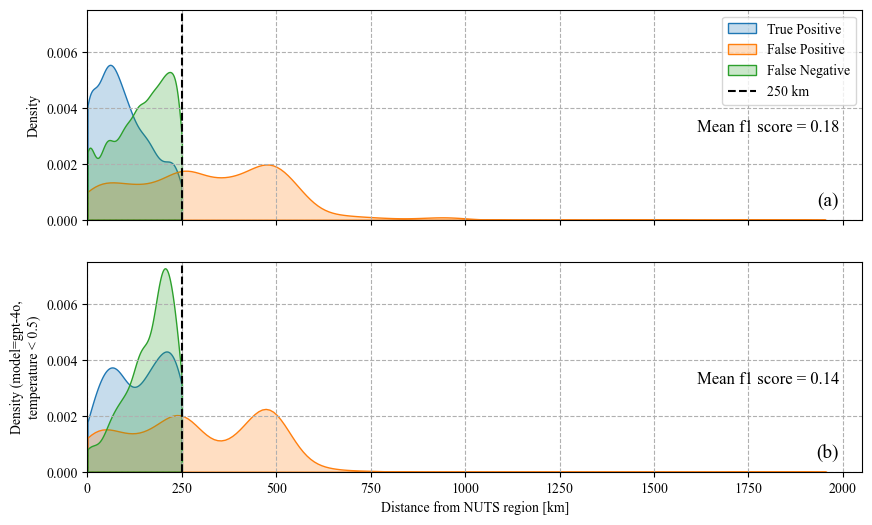

In [63]:
TP = []
FP = []
FN = []

_ = only_level2_250km.apply(populate_all_the_lists, axis=1)

fig, axs = plt.subplots(2, figsize=(10, 6), sharex=True)

ax = axs[0]
sns.kdeplot(TP, fill=True, clip=(0, 250), label=f"True Positive", ax=ax) 
sns.kdeplot(FP, fill=True, clip=(0, None), label=f"False Positive", ax=ax)
sns.kdeplot(FN, fill=True, clip=(0, 250), label=f"False Negative", ax=ax)
ax.axvline(250, color="black", label="250 km", linestyle="dashed")
ax.set_xlim(0, None)
ax.set_ylim(0, 0.0075)
ax.legend()
ax.grid(linestyle='dashed')
ax.text(0.97, 0.05, "(a)", 
        transform=ax.transAxes,
        fontsize=14,
        ha='right',
        va='bottom')

ax.text(0.97, 0.4, f"Mean f1 score = {round(only_level2_250km.f1_non_rag.mean(), 2)}", 
        transform=ax.transAxes,
        fontsize=12,
        ha='right',
        va='bottom')



TP = []
FP = []
FN = []

only_gpt4o = only_level2_250km[only_level2_250km["model_str"] == "gpt-4o"]
only_gpt4o = only_gpt4o[only_gpt4o["temperature"] == 0]
_ = only_gpt4o.apply(populate_all_the_lists, axis=1)

ax = axs[1]
sns.kdeplot(TP, fill=True, clip=(0, 250), label=f"True Positive", ax=ax) 
sns.kdeplot(FP, fill=True, clip=(0, None), label=f"False Positive", ax=ax)
sns.kdeplot(FN, fill=True, clip=(0, 250), label=f"False Negative", ax=ax)
ax.axvline(250, color="black", label="250 km", linestyle="dashed")
ax.set_xlim(0, None)
ax.set_ylim(0, 0.0075)
ax.grid(linestyle='dashed')
ax.set_xlabel("Distance from NUTS region [km]")
ax.set_ylabel("Density (model=gpt-4o,\ntemperature < 0.5)")
ax.text(0.97, 0.05, "(b)", 
        transform=ax.transAxes,
        fontsize=14,
        ha='right',
        va='bottom')
ax.text(0.97, 0.4, f"Mean f1 score = {round(only_gpt4o.f1_non_rag.mean(), 2)}", 
        transform=ax.transAxes,
        fontsize=12,
        ha='right',
        va='bottom')

fig.savefig("pics/KDE_distance.png", bbox_inches="tight")

Generally: 
- FN (missing) rise, the closer to the limit -> model is careful
- FPs see a bump around the limit -> makes sense
- FPS see a second bump at ~500 -> the model might confuse radius with diameter. 

# Some bad examples

In [66]:
df = results[results.temperature < 0.5]
df = df[df.model_str == "gpt-4o"]
df = df[df.question_raw == "What is the largest city that can be found within the bounding box of the NUTS region CODE?"]

In [67]:
q = """
PREFIX geo: <http://www.opengis.net/ont/geosparql#> 
PREFIX geof: <http://www.opengis.net/def/function/geosparql/> 
PREFIX gn: <https://www.geonames.org/ontology#> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX nutsdef: <http://data.europa.eu/nuts/>

SELECT ?city ?notation ?codeWKT
WHERE {
  ?code a skos:Concept ;
    	skos:notation ?notation ;
        geo:hasGeometry ?codeGeom .
    BIND(str(?codeGeom) as ?temp)
    FILTER(CONTAINS(?temp, "ETRS89"))
  ?codeGeom geo:asWKT ?codeWKT .
}"""

# get only the cities that were at least 10 times the example

codes = sparql_select(q)
codes["codeWKT"] = codes["codeWKT"].apply(wkt.loads)
codes = gpd.GeoDataFrame(codes, geometry="codeWKT", crs=3035)
codes = codes.to_crs(4326)

In [68]:
cities = gpd.GeoDataFrame(cities, geometry="cityWKT", crs=3035)
cities = cities.to_crs(4326)

In [69]:
def p(row):
    print(row.name)
    print(row.populated_question)
    print(row.gt_results_from_graph_db)
    print(row.non_rag_answers)

In [70]:
def plot_bbox(row, ax):
    region = row.inputs["CODE"]
    geom = codes[codes['notation'] == region].codeWKT.values[0]
    minx, miny, maxx, maxy = geom.bounds
    bbox = box(minx, miny, maxx, maxy)

    plot_polygon(geom, ax=ax, add_points=False, alpha=0.5, edgecolor="blue", facecolor="lightblue")
    plot_polygon(bbox, ax=ax, add_points=False, edgecolor="red", linestyle="--")

    city = cities[cities.cityName == list(row.detected_answers_non_rag)[0]].cityWKT.values[0]
    ax.scatter(city.x, city.y)

    ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik)
    ax.axis("off")
    return ax

In [71]:
# fig, axs = plt.subplots(2, 2, figsize=(15, 15))
# plot_bbox(df.loc[28758], axs[0][0])

# plot_bbox(df.loc[28272], axs[0][1])

# plot_bbox(df.loc[28038], axs[1][0])

# plot_bbox(df.loc[6276], axs[1][1])

# Load again the results

In [ ]:
results = pd.concat([pickleload(f"data/with_assessment_{i}.pkl") for i in range(10)])

# Examples for Maps explaining semantics

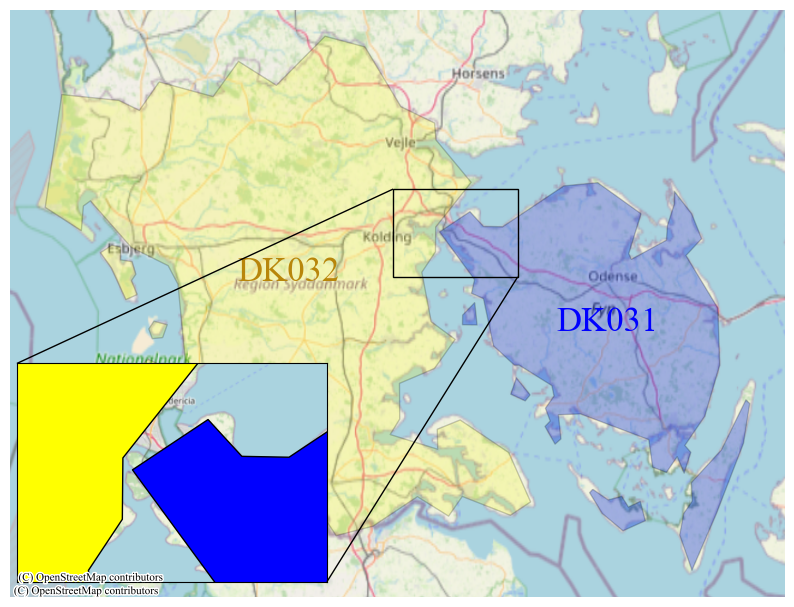

In [75]:
dk031 = codes[codes.notation == "DK031"]
others = codes[codes.notation.apply(lambda x: x in ["DK032", "DK033", "DK034"])]

fig, ax = plt.subplots(1, figsize=(10, 8))
dk031.plot(ax=ax, alpha=0.2, linewidth=4)


dk031.plot(ax=ax, color='blue', edgecolor='black', alpha=0.2, label='GeoDataFrame 1')
others.plot(ax=ax, color='yellow', edgecolor='black', alpha=0.2, label='GeoDataFrame 2')

for idx, row in dk031.iterrows():
    plt.text(row.codeWKT.centroid.x, row.codeWKT.centroid.y, row["notation"], fontsize=25, ha='center', color='blue')

for idx, row in others.iterrows():
    plt.text(row.codeWKT.centroid.x, row.codeWKT.centroid.y, row["notation"], fontsize=25, ha='center', color='darkgoldenrod')

ax_inset = inset_axes(ax, width="40%", height="40%", loc='lower left')
dk031.plot(ax=ax_inset, color='blue', edgecolor='black', alpha=1)
others.plot(ax=ax_inset, color='yellow', edgecolor='black', alpha=1)
ax_inset.set_xticks([])
ax_inset.set_yticks([])
ax_inset.set_xlim(9.5, 10)
ax_inset.set_ylim(55.4, 55.6)
ctx.add_basemap(ax_inset, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)

mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec="black")

ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik)
ax.axis("off")

fig.savefig("pics/DKregions.png", bbox_inches="tight")

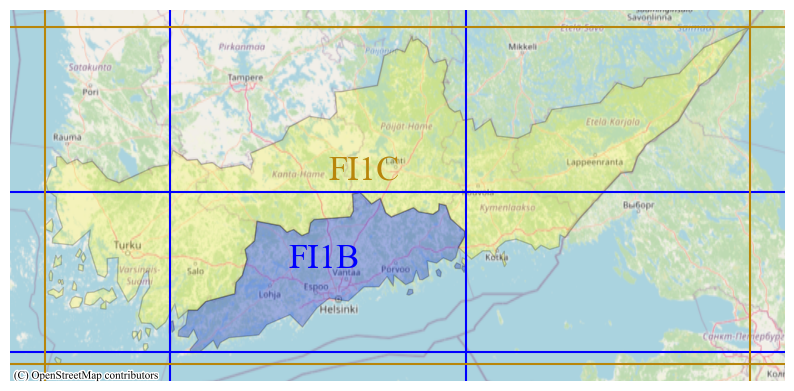

In [76]:
dk031 = codes[codes.notation == "FI1B"]
others = codes[codes.notation == "FI1C"]

fig, ax = plt.subplots(1, figsize=(10, 8))
dk031.plot(ax=ax, alpha=0.2, linewidth=4)


dk031.plot(ax=ax, color='blue', edgecolor='black', alpha=0.2, label='GeoDataFrame 1')
ax.axvline(dk031.bounds.values[0][0], color='blue')
ax.axvline(dk031.bounds.values[0][2], color='blue')
ax.axhline(dk031.bounds.values[0][1], color='blue')
ax.axhline(dk031.bounds.values[0][3], color='blue')

others.plot(ax=ax, color='yellow', edgecolor='black', alpha=0.2, label='GeoDataFrame 2')
ax.axvline(others.bounds.values[0][0], color="darkgoldenrod")
ax.axvline(others.bounds.values[0][2], color="darkgoldenrod")
ax.axhline(others.bounds.values[0][1], color="darkgoldenrod")
ax.axhline(others.bounds.values[0][3], color="darkgoldenrod")

for idx, row in dk031.iterrows():
    plt.text(row.codeWKT.centroid.x, row.codeWKT.centroid.y, row["notation"], fontsize=25, ha='center', color='blue')

for idx, row in others.iterrows():
    plt.text(row.codeWKT.centroid.x, row.codeWKT.centroid.y, row["notation"], fontsize=25, ha='center', color='darkgoldenrod')


ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik)
ax.axis("off")

fig.savefig("pics/FIregions.png", bbox_inches="tight")

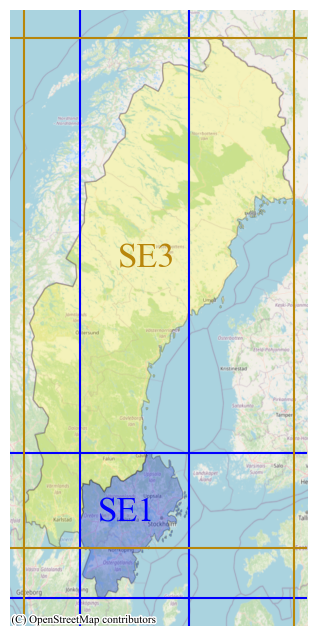

In [77]:
dk031 = codes[codes.notation == "SE1"]
others = codes[codes.notation == "SE3"]

fig, ax = plt.subplots(1, figsize=(10, 8))
dk031.plot(ax=ax, alpha=0.2, linewidth=4)


dk031.plot(ax=ax, color='blue', edgecolor='black', alpha=0.2, label='GeoDataFrame 1')
ax.axvline(dk031.bounds.values[0][0], color='blue')
ax.axvline(dk031.bounds.values[0][2], color='blue')
ax.axhline(dk031.bounds.values[0][1], color='blue')
ax.axhline(dk031.bounds.values[0][3], color='blue')

others.plot(ax=ax, color='yellow', edgecolor='black', alpha=0.2, label='GeoDataFrame 2')
ax.axvline(others.bounds.values[0][0], color="darkgoldenrod")
ax.axvline(others.bounds.values[0][2], color="darkgoldenrod")
ax.axhline(others.bounds.values[0][1], color="darkgoldenrod")
ax.axhline(others.bounds.values[0][3], color="darkgoldenrod")

for idx, row in dk031.iterrows():
    plt.text(row.codeWKT.centroid.x, row.codeWKT.centroid.y, row["notation"], fontsize=25, ha='center', color='blue')

for idx, row in others.iterrows():
    plt.text(row.codeWKT.centroid.x, row.codeWKT.centroid.y, row["notation"], fontsize=25, ha='center', color='darkgoldenrod')


ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik)
ax.axis("off")

fig.savefig("pics/SEregions.png", bbox_inches="tight")

# Check how many of the non-RAG neighbor answers are from the same country

In [79]:
codes = results[results.answer_type == "code_iri"]
codes = codes[codes.question_raw.str.contains("neighbor")]
codes["column_to_analyze"] = codes["column_to_analyze"].apply(lambda x: set(x) if x is not None else set())
codes["gt_results_set"] = codes.apply(lambda x: set(x["gt_results_from_graph_db"][x["gt_results_column"]]) ,axis=1)

In [80]:
def get_letter_ratio(row, column):
    letter = row.inputs["CODE"][:2]
    if len(row[column]) > 0:
        same = [True if letter == res.split("/")[-1][:2] else False for res in list(row[column])]
        ratio = sum(same) / len(row[column])
        return ratio
    

print(codes.apply(get_letter_ratio, column="gt_results_set", axis=1).mean())
print(codes.apply(get_letter_ratio, column="detected_answers_non_rag", axis=1).mean())
print(codes.apply(get_letter_ratio, column="column_to_analyze", axis=1).mean())

0.7680248055625385
0.9552177903843403
0.7499345384367431
